In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
FILE_PATH = "pkn_d_2010_2015.csv"
BATCH_SIZE = 4
TRAIN_TEST_RATIO = 0.8
NUM_EPOCHS = 40
LR_RATE = 0.0001
IN_SIZE = 3

   Zamkniecie  Wolumen
0      28.342  2714185
1      29.383  3139061
2      29.463  1547639


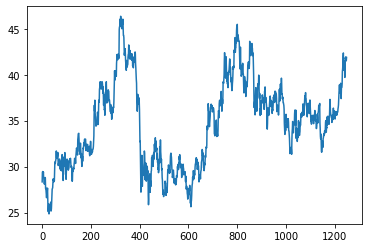

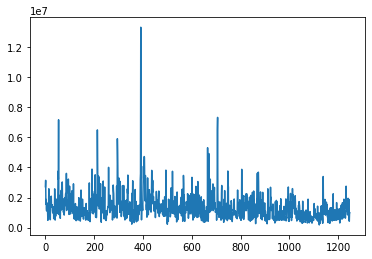

tensor([[2.4858e+01, 1.8088e+05]])


tensor([[2.9383e+01, 3.1391e+06],
        [2.9463e+01, 1.5476e+06],
        [2.9422e+01, 1.8709e+06],
        [2.9022e+01, 1.2549e+06]])

In [60]:
data = pd.read_csv(FILE_PATH)
data = data.drop(["Data","Otwarcie","Najwyzszy","Najnizszy"], axis=1)
print(data.head(3))
plt.plot(data["Zamkniecie"])
plt.show()
plt.plot(data["Wolumen"])
plt.show()
data.dropna(axis=0,inplace=True)
data = torch.Tensor(data.to_numpy())

data_min = torch.min(data, dim=0, keepdim=True).values
data_max = torch.max(data, dim=0, keepdim=True).values
print(data_min)
data[1:5]

In [24]:
class MyDataset(Dataset):
    def __init__(self, data, shift_size, data_min, data_max):
        self.data = data
        self.labels = self.data[0,0]
        self.shift_size = shift_size
        self.data = (self.data - data_min)/(data_max-data_min)
    
    def __len__(self):
        return self.data.shape[0] - self.shift_size

    def __getitem__(self, idx):
        idx += self.shift_size
        x = self.data[(idx-self.shift_size):idx].t().reshape(-1)
        y = self.labels.reshape(1)
        
        return x, y

In [25]:
idx = int(TRAIN_TEST_RATIO*len(data))
train_data = data[:idx]
test_data = data[idx:]
train_data.shape

torch.Size([999, 2])

In [61]:
dataset_train = MyDataset(train_data, IN_SIZE, data_min, data_max)
dataset_test = MyDataset(test_data, IN_SIZE, data_min, data_max)
trainloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
dataset_test[0][0], dataset_test[0][1]


(tensor([0.4213, 0.5040, 0.4797, 0.0180, 0.0622, 0.0420]), tensor([33.9140]))

In [27]:
x, y = next(iter(trainloader))
print(y.shape)
x.shape

torch.Size([4, 1])


torch.Size([4, 6])

In [12]:
class NeuralNetwork(nn.Module):
    def __init__ (self,input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        return x
    
    

In [32]:
model = NeuralNetwork(input_size=2*IN_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)

In [33]:
#learning the model
model.train()
for epoch in range(NUM_EPOCHS):
    print("epoch: {}".format(epoch))
    train_loss = 0.0
    for x, y in trainloader:
        #zero the parameters gradient
        optimizer.zero_grad()
        
        #forward, backward, optimize
        output = model(x)
        loss = criterion(output, y)
        train_loss += loss
        loss.backward()
        optimizer.step()
    print("train_loss: {}".format(train_loss / len(trainloader)))
    
    
    test_loss = 0.0
    model.eval()
    for x, y in testloader:
        output = model(x)
        loss = criterion(output, y)
        test_loss += loss
    print("test_loss: {}".format(test_loss / len(testloader)))
    model.train()
        

epoch: 0
train_loss: 793.52001953125
test_loss: 1127.7850341796875
epoch: 1
train_loss: 772.7404174804688
test_loss: 1094.702880859375
epoch: 2
train_loss: 736.9576416015625
test_loss: 1038.0435791015625
epoch: 3
train_loss: 679.5
test_loss: 950.8909301757812
epoch: 4
train_loss: 596.9867553710938
test_loss: 830.7621459960938
epoch: 5
train_loss: 492.39312744140625
test_loss: 685.0593872070312
epoch: 6
train_loss: 376.8279724121094
test_loss: 529.2603149414062
epoch: 7
train_loss: 265.4796142578125
test_loss: 381.615234375
epoch: 8
train_loss: 172.80267333984375
test_loss: 258.4371337890625
epoch: 9
train_loss: 107.79500579833984
test_loss: 169.26434326171875
epoch: 10
train_loss: 70.54830932617188
test_loss: 113.79400634765625
epoch: 11
train_loss: 53.26348114013672
test_loss: 83.7085952758789
epoch: 12
train_loss: 46.24217987060547
test_loss: 68.78440856933594
epoch: 13
train_loss: 43.13233184814453
test_loss: 61.58734893798828
epoch: 14
train_loss: 41.26035690307617
test_loss: 58.03

In [34]:
x,y = next(iter(testloader))
print(x)
print(y)
print(model(x))

tensor([[0.4213, 0.5040, 0.4797, 0.0180, 0.0622, 0.0420],
        [0.5040, 0.4797, 0.4636, 0.0622, 0.0420, 0.1156],
        [0.4797, 0.4636, 0.4597, 0.0420, 0.1156, 0.0920],
        [0.4636, 0.4597, 0.4366, 0.1156, 0.0920, 0.1142]])
tensor([[33.9140],
        [33.9140],
        [33.9140],
        [33.9140]])
tensor([[26.2183],
        [27.1977],
        [27.3206],
        [27.8403]], grad_fn=<ReluBackward0>)


In [35]:
print(trainloader)

In [53]:
# making predictions
predictions_raw = []
model.eval()
for x,y in testloader:
    #print(data)
    #inputs, labels = data[0].reshape(1,6), data[1]
    #print(inputs.shape)
    for i in x:  
        predicted = model(i)
        predictions_raw.append(predicted)
predictions = np.asarray([float(i) for i in predictions_raw])

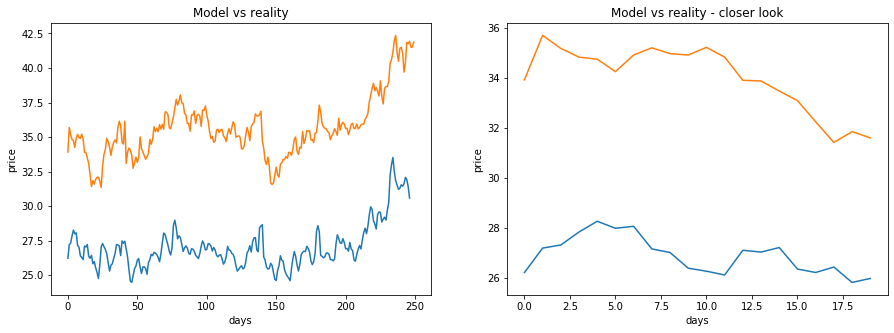

In [56]:
plt.figure(figsize=(15,5))
plt.subplot(121,xlabel="days", ylabel="price")
plt.plot(predictions)
plt.plot(test_data[:,0])
plt.title("Model vs reality")
#krotszy okres czasu
plt.subplot(122,xlabel="days", ylabel="price")
plt.plot(predictions[:20])
plt.plot(test_data[:,0][:20])
plt.title("Model vs reality - closer look")
plt.show()


In [ ]:
print(test_min_max[1][0][0])
print(predictions[:10])
test_min_max[0][0][0]

In [ ]:
#najpierw "odskaluje" dane
predictions = torch.Tensor(predictions)
print(predictions[:10])
predictions = predictions*(test_min_max[1][0][0]-test_min_max[0][0][0])+test_min_max[0][0][0]
#tutaj pasuje sie zastanowic czy nie ma bledu metodologicznego
#bo mam watpliwosci czy uzywanie statystyk zbioru testowego dla predykcji jest uzasadnione
test = test*(test_min_max[1]-test_min_max[0])+test_min_max[0]

plt.plot(np.array(predictions))
plt.plot(test[:,0])
plt.show()
predictions[:10]